# Contextualização do problema
## Classificação de Obesidade
"""
Este notebook utiliza métodos clássicos de machine learning para classificar dados de obesidade.
O conjunto de dados contém variáveis relacionadas ao comportamento alimentar e à saúde,
com o objetivo de prever a categoria de obesidade de um indivíduo.

Etapas:
- Carregamento e pré-processamento dos dados
- Treinamento e avaliação de modelos (KNN, Árvore de Decisão, Naive Bayes, SVM)
- Comparação dos resultados dos modelos
- Otimização de hiperparâmetros
- Exportação do modelo
"""

##Montando o Google Drive

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Configuração para não exibir warnings

In [70]:
import warnings
warnings.filterwarnings("ignore")

##Imports necessários

In [71]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

##Carrega o dataset

In [72]:
dataset = pd.read_csv('/content/drive/MyDrive/ObesityDataSet_raw_and_data_sinthetic.csv')
dataset.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


##Define variaveis

In [73]:

test_size = 0.20
seed = 7
num_particoes = 10
scoring = 'accuracy'

##Verifica valores únicos nas colunas categoricas

In [74]:
cat_cols = ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']
for col in cat_cols:
    print(f'Valores únicos em {col}: {dataset[col].unique()}')

Valores únicos em Age: [21.       23.       27.       ... 22.524036 24.361936 23.664709]
Valores únicos em Gender: ['Female' 'Male']
Valores únicos em Height: [1.62     1.52     1.8      ... 1.752206 1.73945  1.738836]
Valores únicos em Weight: [ 64.        56.        77.       ... 133.689352 133.346641 133.472641]
Valores únicos em CALC: ['no' 'Sometimes' 'Frequently' 'Always']
Valores únicos em FAVC: ['no' 'yes']
Valores únicos em FCVC: [2.       3.       1.       2.450218 2.880161 2.00876  2.596579 2.591439
 2.392665 1.123939 2.027574 2.658112 2.88626  2.714447 2.750715 1.4925
 2.205439 2.059138 2.310423 2.823179 2.052932 2.596364 2.767731 2.815157
 2.737762 2.568063 2.524428 2.971574 1.0816   1.270448 1.344854 2.959658
 2.725282 2.844607 2.44004  2.432302 2.592247 2.449267 2.929889 2.015258
 1.031149 1.592183 1.21498  1.522001 2.703436 2.362918 2.14084  2.5596
 2.336044 1.813234 2.724285 2.71897  1.133844 1.757466 2.979383 2.204914
 2.927218 2.88853  2.890535 2.530066 2.241606 1.00

# Visualização da distribuição das classes no target

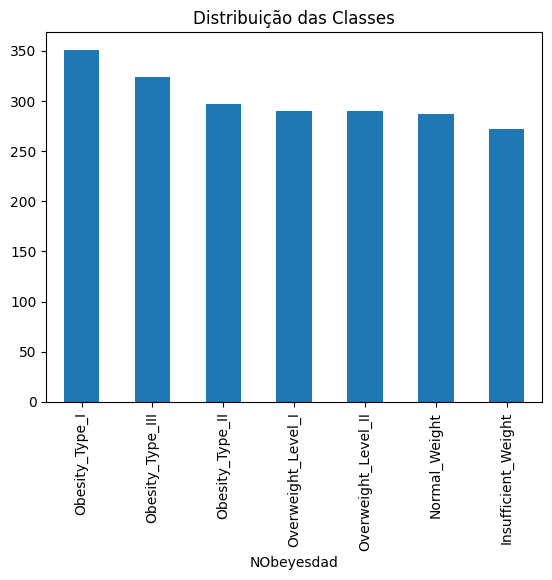

In [75]:
dataset['NObeyesdad'].value_counts().plot(kind='bar')
plt.title('Distribuição das Classes')
plt.show()

##checa valores nulos e duplicados

In [76]:
dataset.drop_duplicates(inplace=True)
print(f"Nulos: {dataset.isnull().sum().sum()}, Duplicatas: {dataset.duplicated().sum()}")

Nulos: 0, Duplicatas: 0


## Codificando a coluna 'NObeyesdad' (o alvo) com LabelEncoder

In [77]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['NObeyesdad'])

## Substituindo a coluna 'NObeyesdad' codificada no dataset

In [78]:
dataset['NObeyesdad'] = y

# Salvando o LabelEncoder para uso posterior (na API)

In [79]:
with open('/content/drive/MyDrive/nobeyesdad_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

## One-hot encoding para as outras colunas categóricas

In [80]:
dataset = pd.get_dummies(dataset, columns=['Gender', 'CALC', 'FAVC', 'NCP', 'SCC', 'SMOKE', 'family_history_with_overweight', 'CAEC', 'MTRANS'])

## Separação entre features e target

In [81]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

## Separação entre treino e teste

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

# Ajuste o scaler com base nos dados de treino

In [83]:
scaler = StandardScaler().fit(X_train)

## Padronize os dados de treino e teste

In [84]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Definição de modelos

In [85]:
models = [
    ('LR', LogisticRegression(max_iter=200)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('Bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100))
]

## Validação cruzada e avaliação dos modelos

In [86]:
results, names = [], []
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.3f} ({cv_results.std():.3f})")


LR: 0.993 (0.005)
KNN: 0.974 (0.003)
CART: 1.000 (0.000)
NB: 0.999 (0.002)
SVM: 0.974 (0.003)
Bagging: 1.000 (0.000)


## Boxplot de comparação

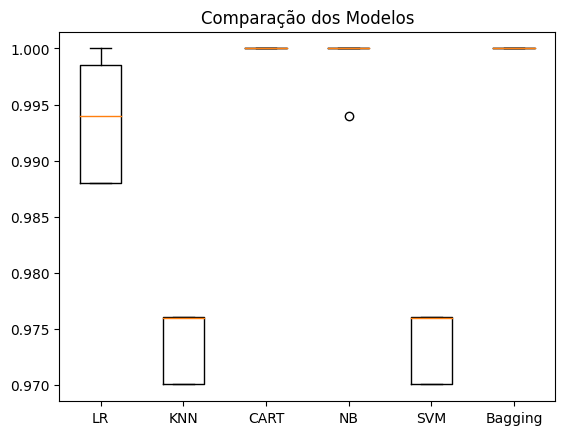

In [87]:
#plt.figure(figsize=(15, 10))
plt.boxplot(results)
plt.xticks(range(1, len(names) + 1), names)
plt.title('Comparação dos Modelos')
plt.show()

## Criação de pipelines para diferentes tipos de escalação

In [88]:
scalers = [('StandardScaler', StandardScaler()), ('MinMaxScaler', MinMaxScaler())]
for scaler_name, scaler in scalers:
    for name, model in models:
        pipeline = Pipeline([(scaler_name, scaler), (name, model)])
        cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
        print(f"{name} ({scaler_name}): {cv_results.mean():.3f} ({cv_results.std():.3f})")

LR (StandardScaler): 0.999 (0.002)
KNN (StandardScaler): 0.973 (0.005)
CART (StandardScaler): 1.000 (0.000)
NB (StandardScaler): 0.999 (0.002)
SVM (StandardScaler): 0.974 (0.003)
Bagging (StandardScaler): 1.000 (0.000)
LR (MinMaxScaler): 0.992 (0.005)
KNN (MinMaxScaler): 0.977 (0.007)
CART (MinMaxScaler): 1.000 (0.000)
NB (MinMaxScaler): 0.999 (0.002)
SVM (MinMaxScaler): 0.998 (0.004)
Bagging (MinMaxScaler): 1.000 (0.000)


## RandomizedSearchCV com BaggingClassifier

In [89]:
param_grid = {
    'Bagging__n_estimators': [50, 100],
    'Bagging__max_samples': [0.5, 0.7, 1.0],
    'Bagging__max_features': [0.5, 0.7, 1.0],
    'Bagging__bootstrap': [True, False],
    'Bagging__bootstrap_features': [True, False]
}
bagging_pipeline = Pipeline([('StandardScaler', StandardScaler()), ('Bagging', BaggingClassifier(random_state=7, n_jobs=-1))])
random_search = RandomizedSearchCV(bagging_pipeline, param_grid, n_iter=10, scoring=scoring, cv=kfold, random_state=seed, n_jobs=-1)
random_search.fit(X_train, y_train)
print(f"Melhor: {random_search.best_score_:.3f} usando {random_search.best_params_}")

Melhor: 0.995 usando {'Bagging__n_estimators': 100, 'Bagging__max_samples': 0.5, 'Bagging__max_features': 0.7, 'Bagging__bootstrap_features': False, 'Bagging__bootstrap': False}


teste

In [90]:
# Melhor pipeline encontrado pelo RandomizedSearchCV
best_pipeline = random_search.best_estimator_

# Avaliação no conjunto de teste
predictions = best_pipeline.predict(X_test_scaled)
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, predictions):.3f}")

Acurácia no conjunto de teste: 1.000


## Estimativa da acurácia no conjunto de teste

In [64]:
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
best_pipeline = random_search.best_estimator_
model = best_pipeline
model.fit(rescaledX, y_train)
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = best_pipeline.predict(rescaledTestX)
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, predictions):.3f}")

Acurácia no conjunto de teste: 0.995


## Avaliação no conjunto de teste

In [ ]:
#best_pipeline = random_search.best_estimator_
#predictions = best_pipeline.predict(scaler.transform(X_test))
#print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, predictions):.3f}")

## Salvando os modelos

In [91]:
model_filename = '/content/drive/MyDrive/bg_obesidade_classifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_pipeline.named_steps['Bagging'], file)

##Salvando scaler

In [92]:
# Salvando o scaler
scaler_filename = '/content/drive/MyDrive/standard_scaler_obesidade.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

## Salvando o pipeline com RandomizedSearchCV

In [93]:
pipeline_filename = '/content/drive/MyDrive/bg_obesidade_pipeline.pkl'
with open(pipeline_filename, 'wb') as file:
    pickle.dump(best_pipeline, file)

## Salvando X_test e y_test

In [94]:
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("/content/drive/MyDrive/X_test_dataset_obesidade.csv", index=False)
y_test_df.to_csv("/content/drive/MyDrive/y_test_dataset_obesidade.csv", index=False)

teste

In [ ]:
# Estimativa da acurácia no conjunto de teste

#scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
#rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
#best_pipeline = random_search.best_estimator_
#model = best_pipeline
#model.fit(rescaledX, y_train)
#rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
##saidas = best_pipeline.predict(rescaledEntradaX)  # Use 'best_pipeline' aqui também
##print(saidas)
#predictions = best_pipeline.predict(rescaledTestX)
##print(accuracy_score(y_test, predictions))
#print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, predictions):.3f}")

#data = {'Age': [21.0, 50, 60],
#        'Gender': ['Female', 'Male', 'Female'],
#        'Height': [1.62, 1.80, 1.50],
#        'Weight': [64.0, 100.0, 70.0],
#        'CALC': ['no', 'no', 'Frequently'],
#        'FAVC': [2.0 , 1.0 , 1.0],
#        'FCVC': [3.0, 1.0, 2.0],
#        'NCP': ['no', 'yes' , 'no'],
#        'SCC': ['no' , 'yes', 'no'],
#        'SMOKE': ['no','no','no'],
#        'CH2O': [2.0, 1.0, 1.0],
#        'family_history_with_overweight': ['yes', 'yes', 'no'],
#        'FAF': [0.0, 1.0, 0.0],
#        'TUE': [1.0, 2.0, 1.0],
#        'CAEC': ['Sometimes','Sometimes','Sometimes'],
#        'MTRANS': ['Public_Transportation', 'Walking', 'Walking']  # Corrigido para ter 3 elementos
#        }

#atributos = ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS']
#entrada = pd.DataFrame(data, columns=atributos)

## Converta as variáveis categóricas em variáveis numéricas
#entrada_encoded = pd.get_dummies(entrada)

#entrada_encoded = entrada_encoded.reindex(columns=X_train.columns, fill_value=0)  # Assegurar que as colunas estão alinhadas
##array_entrada = entrada.values
##X_entrada = array_entrada.astype(float)

## Padronização nos dados de entrada usando o scaler utilizado em X
#rescaledEntradaX = scaler.transform(entrada_encoded)
#print(rescaledEntradaX)

## Predição de classes dos dados de entrada
#saidas = best_pipeline.predict(rescaledEntradaX)
#print(saidas)